# Maze Roller --> Step 1

## Echtdaten einlesen

In [23]:
fileName="beideAchsen"

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy as sp
import scipy.linalg as linalg
sp.init_printing(use_latex='mathjax')

In [32]:
def ReadData(NameDerMessreihe, tstart=0, tend=None, info=False):
    lines = open('%s_daten.csv'%NameDerMessreihe, 'r').readlines()
    del lines[-1]
    del lines[0]
    open('%s_daten.csv'%NameDerMessreihe, 'w').writelines(lines) 
    
    src=open('%s_daten.csv'%NameDerMessreihe,"r")
    fline="time,GyroX,GyroY,GyroZ,AccX,AccY,AccZ,GyroX2,GyroY2,GyroZ2,AccX2,AccY2,AccZ2\n"    #Prepending string
    oline=src.readlines()
    oline.insert(0,fline)
    src.close()
    src=open('%s_daten.csv'%NameDerMessreihe,"w")
    src.writelines(oline)
    src.close()
    
    data = pd.read_csv('%s_daten.csv'%NameDerMessreihe)
    data.time /= 1000                        #Umwandlung in Sekunden
    data.time -= data.time[0]                #Erste Messung auf t=0s setzen
    data = data[data.time>=tstart]
    if tend is not None:
        data = data[data.time<=tend]

    
    if info:
        with open('%s_beschreibung.txt'%NameDerMessreihe, encoding='utf-8') as fd:
            print(fd.read())
            
        display(data.head(5))
#        display(data.tail(3))
    return data
#data = ReadData(fileName, info=True)

# Kalman-Filter (mit einem Sensor)

Unser Systemzustand x, wobei $\dot{\phi} $ die Ableitung vom Winkel darstellt:
$$     x =\left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \phi_{Offset}\\
       \end{matrix}\right]
$$

Unsere Messwerte y: 
$$     y =\left[\begin{matrix}gyro.x\\
       \end{matrix}\right]
$$

## Systemtransfer-Matrix

In [26]:
A = np.matrix([
    [0, 1, 0],
    [0, 0, 0],
    [0, 0, 0]
])
Ts_sym = sp.symbols('Ts')
sp.exp( sp.Matrix(A) * Ts_sym)

⎡1.0  1.0⋅Ts  0⎤
⎢              ⎥
⎢ 0     1     0⎥
⎢              ⎥
⎣ 0     0     1⎦

In [27]:
Ad = np.eye(3) + Ts*A 
Ad

matrix([[ 1.   ,  0.033,  0.   ],
        [ 0.   ,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  1.   ]])

Die Control-Input B entfällt in folgendem durch fehlendem u(t):

$$     x_{n+1} = Ad_{x_n} + Gd_{z_n} $$

$$
       \left[\begin{matrix}\phi_{n+1}\\
       \dot{\phi_{n+1}}\\
       \phi_{Offset}\\
       \end{matrix}\right] = \left[\begin{matrix} 1 & Ts & 0\\
       0 & 1 & 0\\
       0 & 0 & 1\\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi_{n}\\
       \dot{\phi_{n}}\\
       \phi_{Offset}\\
       \end{matrix}\right]
$$

Für unseren Sensor gilt:
$$ \phi_{neu} = \phi_{alt} + \dot{\phi_{alt}} \cdot Ts - \phi_{Offset} \cdot Ts $$

Den Offset bringen wir durch unseren Vektor C hinein. In A ist dies nicht möglich, da dann ein Fehler in der Konsistenz entsteht.

In [28]:
#x =  [phi,
#      phidot,
#      gyrooffset]

A = np.matrix([
    [0, 1, 0],
    [0, 0, 0],
    [0, 0, 0]
])

#A * x =  [phidot - gyrooffset, 
#           0,
#        ´  0]
#xdot = A * x

Ad = np.matrix([
    [1, Ts, 0],
    [0, 1, 0],
    [0, 0, 1]
])

#x_k = Ad * x_k-1

## Die Messmatrix C

$$ y = \dot{\phi} - \phi_{Offset}\\
y = C \cdot x = \left[\begin{matrix} 0 & 1 & -1\\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \phi_{Offset}\\
       \end{matrix}\right] $$ 

In [29]:
#C*x = phidot

C = np.matrix([
    [0, 1, -1]
])

## Das Prozessrauschen

$$
\dot{\mathbf x}(t) = A\mathbf x(t) + B\mathbf u(t) + G \mathbf z(t)
$$
$$
\left[\begin{matrix}\dot{\phi}\\
       \ddot{\phi}\\
       \dot{\phi_{Offset}}\\
       \end{matrix}\right] = \left[\begin{matrix} 0 & 1 & 0\\
       0 & 0 & 0\\
       0 & 0 & 0\\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \phi_{Offset}\\
       \end{matrix}\right] + \left[\begin{matrix}0\\
       z_1\\
       z_2\\
       \end{matrix}\right]
$$

Im folgenden wird $G$ gebildet:
$$
 G = \left[\begin{matrix}0\\
       z_1\\
       z_2\\
       \end{matrix}\right] =  \left[\begin{matrix}0 & 0\\
       1 & 0\\
       0 & 1 \\
       \end{matrix}\right] \cdot \left[\begin{matrix}z_1\\
       z_2\\
       \end{matrix}\right]
$$
Im folgenden wird $G_d$ gebildet:
$$
 G_d = \int\limits_{0}^{T_s} A_d \cdot G\, d\tau = 
 \int\limits_{0}^{T_s} \begin{bmatrix}1&Ts&0\\0&1&0\\0&0&1\end{bmatrix} \cdot  
 \left[\begin{matrix}0 & 0\\1 & 0\\0 & 1\end{matrix}\right] 
 \, d\tau
 = \int\limits_{0}^{T_s} \begin{bmatrix}Ts&0\\1&0\\0&1\end{bmatrix}\, d\tau
$$
$$
 G_d = \begin{bmatrix}1/2Ts^2&0\\Ts&0\\0&Ts\end{bmatrix}\
$$

In [30]:
Gd = np.matrix([[0.5*Ts**2, 0], 
                [Ts, 0], 
                [0, Ts]])

## Der Filter

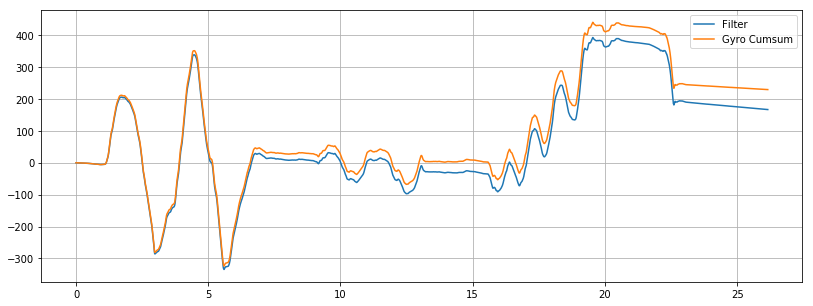

In [36]:
data = ReadData(fileName, info=False)
Ts = 33e-3

y_phi = np.arctan2(data.AccY, data.AccZ) / np.pi * 180
y_gyro = np.array(data.GyroX)
y = y_gyro
#y = np.concatenate( (y_phi[:,np.newaxis], y_gyro[:,np.newaxis]), axis=1)

#Hier kommt Ihr Filter

Bd = 0
#D = np.matrix([0,1]).T


Q = np.diag([1,0])     #var(y_gyro), var(y_offset)
R = 1      #var(phix) , var(ygyro) [wird ignoriert, da in Q enthalten]

N = len(data.time)
x = list()
P = list()
K = list()

for n in range(N):
    #yn = y[n:(n+1),:].T
    yn = y[n]
    if n == 0:
        xlast = np.matrix([0,0,-1]).T
        Plast = np.diag([1,1,1])*100
    else:
        xlast = x[n-1]
        Plast = P[n-1]
    
    x_priori = Ad * xlast
    P_priori = Ad * Plast * Ad.T + Gd * Q * Gd.T
    S = C * P_priori * C.T + R
    Kn = P_priori * C.T * linalg.pinv(S)
    x_post = x_priori + Kn*(yn - C*x_priori)
    P_post = (np.eye(3) - Kn*C)*P_priori
    
    x.append(x_post)
    P.append(P_post)
    K.append(Kn)

x = np.array(x).squeeze()
P = np.array(P).squeeze()
K = np.array(K).squeeze()

###END SOLUTION

plt.figure(figsize=(30, 5))
plt.subplot(121)
#plt.plot(data.time, y_phi, label='Acc-Data')
plt.plot(data.time, x[:,0], label='Filter')
plt.plot(data.time, y_gyro.cumsum()*Ts, label='Gyro Cumsum')
#plt.plot(data.time, x[:,1].cumsum(), label='Offset Cumsum')

#plt.plot(data.time, x[:,2], label='Offset')
#plt.plot(data.time, x[:,1], label='phidot')
#plt.plot(data.time, x[:,1]+x[:,2], label='phidot+offset')
#plt.plot(data.time, y_gyro, label='Gyro')
plt.grid()
plt.legend()



In [37]:
x

array([[ -2.01940304e-02,  -6.11943647e-01,  -3.88063017e-01],
       [ -4.59203327e-02,  -6.95902040e-01,  -3.04288909e-01],
       [ -7.31429658e-02,  -7.39114161e-01,  -2.61358801e-01],
       ..., 
       [  1.67091103e+02,  -1.95475152e+00,  -6.46996466e-01],
       [  1.67028796e+02,  -1.95255220e+00,  -6.46996466e-01],
       [  1.66961296e+02,  -1.95561786e+00,  -6.46996466e-01]])